In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/My Drive/Mestrado/2021.2/Aprendizagem de Maquina/trabalho_05/')

Mounted at /content/drive


# Imports

In [31]:
import pandas as pd
import numpy as np
from src import plots, utils, pipeline as p
import math
import json
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Artificial I

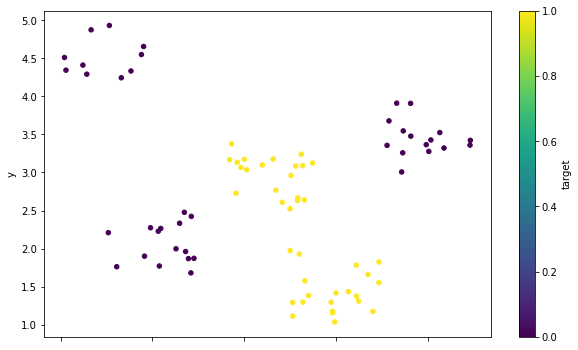

In [3]:
conjunto_1 = utils.make_coords(coord_limit_x = (0, 1), 
                               coord_limit_y = (4, 5),
                               target= 0,
                               len_set = 10) # Top left

conjunto_2 = utils.make_coords(coord_limit_x = (1.75, 2.75), 
                               coord_limit_y = (3.5, 2.5),
                               target= 1,
                               len_set = 20) # Botton left

conjunto_3 = utils.make_coords(coord_limit_x = (2.5, 3.5), 
                               coord_limit_y = (2, 1),
                               target= 1,
                               len_set = 20) # Bottom right
conjunto_4 = utils.make_coords(coord_limit_x = (0.5, 1.5), 
                               coord_limit_y = (1.5, 2.5),
                               target= 0,
                               len_set = 15) # Bottom right

conjunto_5 = utils.make_coords(coord_limit_x = (3.5, 4.5), 
                               coord_limit_y = (3, 4),
                               target= 0,
                               len_set = 15) # Bottom right


df_artificial_1 = pd.DataFrame(data= conjunto_1 + conjunto_2 + conjunto_3 + conjunto_4 + conjunto_5, columns=['x', 'y', 'target'])
# for col in df_artificial_1.columns:
#     if col != 'target':
#         df_artificial_1 = utils.normalize_col(df_artificial_1, col)

df_artificial_1.plot.scatter( x='x', y='y', c='target', colormap='viridis', figsize=(10,6))

In [4]:
df_artificial_1['target'].value_counts()

1    40
0    40
Name: target, dtype: int64

In [5]:
class NormalMultivariate():

    def __init__(self, df, mean=None, cov=None):
        self.df = df
        self.dim = len(df.columns)

        if mean is None: self.mean = np.array([df[col].mean() for col in df.columns  if col != 'target'])
        else: self.mean = np.array(mean)

        if cov is None: self.cov = np.matrix(df.cov().values)
        else: self.cov = np.matrix(cov)

        self.det = np.linalg.det(self.cov)
        self.peak_distribution = 1 / (((2 * np.pi) ** (self.dim / 2)) * 
                                      (self.det ** 0.5))
        self.pseudo_peak_distribution = None
    
    def __compute_pseudo_metrics(self):
        self.pseudo_inv = np.linalg.pinv(self.cov)
        eig_values = np.linalg.eig(self.cov)
        self.pseudo_determinent = np.product([i for i in eig_values[0] if i > 1e-12])
        self.pseudo_peak_distribution = 1 / (((2 * np.pi) ** (self.dim / 2)) * 
                                             (self.pseudo_determinent ** 0.5))

    def pdf(self, x):
        if isinstance(x, pd.core.frame.DataFrame) or isinstance(x[0], list) or isinstance(x[0], np.ndarray) or isinstance(x[0], np.matrix):
            if isinstance(x, pd.core.frame.DataFrame):
                x = x.values
            list_return = []
            for i in x:
                list_return.append(self.__pdf_single_list(i))
            return list_return

        else:
            return self.__pdf_single_list(x)

    def __pdf_single_list(self, x):

        if not isinstance(x, np.ndarray):
            x = np.array(x)
        x_mu = np.matrix(x - self.mean)
        try:
            inv = self.cov.I
            return self.peak_distribution * math.pow(math.e, -0.5 * (x_mu * inv * x_mu.T))
        except np.linalg.LinAlgError as err:
            if self.pseudo_peak_distribution is None:
                self.__compute_pseudo_metrics()
            return self.pseudo_peak_distribution * math.pow(math.e, -0.5 * (x_mu * self.pseudo_inv * x_mu.T))

In [21]:
class GaussianMixtureModel(): 

    def __init__(self, dict_k, iter=2, threshold=0.01):
        self.threshold = threshold
        self.dict_k = dict_k # {class: n_component}
        self.means = {}
        self.means_past = {}
        self.iter = iter

    def __initialize(self, verbose):
      
      if verbose:
          print('*' * 40, 'INICIALIZATION', '*' * 40)
      self.coef_mixture = {}
      for j in sorted(self.list_class):
          self.dict_norm_class[j] = {}
          self.coef_mixture[j] = {}
          if verbose:
              print(f'Class {j}')
          for k, row in zip(range(self.dict_k[j]), self.dict_df_class[j][self.features].sample(n=self.dict_k[j], random_state=42).reset_index(drop=True).iterrows()):
              mean = row[1].tolist()
              self.dict_norm_class[j][k] = NormalMultivariate(self.dict_df_class[j][self.features], mean)  
              self.coef_mixture[j][k] = 1 / self.dict_k[j] # Iniciando Equiprovável

              if verbose:
                  print(f'     Component {k}')
                  print('          Coeficient Mixture:', self.coef_mixture[j][k])
                  print('          Gaussian:')
                  print('               Média da Gaussian:', mean)
                  print('               Covariancia:', self.dict_norm_class[j][k].cov.tolist())

    def __init_list_dict(self, class_):
        list_components = {}
        for k in range(self.dict_k[class_]):
            list_components[k] = [0] * len(self.dict_df_class[class_])
        return list_components

    def __expetation(self, verbose):
        if verbose:
            print('\n', '*' * 40, 'EXPETATION STEP', '*' * 40)
        self.dict_df_components = {} 
        for j in sorted(self.list_class):
            
            if verbose:
                print(f'Class {j}')
            list_components = self.__init_list_dict(j)
            list_component_choose = []
            list_verossimilhanca = []
            
            for idx, _ in self.dict_df_class[j].iterrows():

                x = self.dict_df_class[j][self.features].iloc[idx].tolist()
                list_posteriori = []
                total = 0
                for k in range(self.dict_k[j]):
                    posteriori = self.coef_mixture[j][k] * self.dict_norm_class[j][k].pdf(x)
                    list_posteriori.append(posteriori) # Posteriori
                    total += posteriori
                
                list_verossimilhanca.append(total)
                normalizator = sum(list_posteriori) # Normaliador
                component = 0
                max_reponsability = -np.inf
                for k in range(self.dict_k[j]):
                    # Compute responsability
                    pdf = list_posteriori[k]
                    responsability = pdf / normalizator
                    list_components[k][idx] = responsability
                    if max_reponsability < responsability:
                        max_reponsability = responsability
                        component = k
                list_component_choose.append(component)
            
            self.dict_df_components[j] = pd.DataFrame.from_dict(list_components) # Cada coluna é uma component
            self.dict_df_components[j]['component_choose'] = list_component_choose
            self.dict_df_components[j]['probability'] = list_verossimilhanca
            if verbose:
                display(self.dict_df_components[j].head(5))

    def __maximization(self, verbose):
        if verbose:
            print('\n', '*' * 40, 'MAXIMIZATION STEP', '*' * 40)
        for j in sorted(self.list_class):
            if verbose:
                print(f'Class {j}')
            self.means[j] = {}
            self.means_past[j] = {}
            df_class = self.dict_df_class[j][self.features].copy()
            df_class = df_class.join(self.dict_df_components[j])
            for k in range(self.dict_k[j]):
                if verbose:
                  print(f'Component {k}')
                responsability = df_class[k]
                row = df_class[self.features].values

                sum_mean = np.array([0] * (len(self.features)))
                for x, resp in zip(row, responsability):
                    sum_mean = sum_mean + (x * resp)

                # Updating Mean
                new_mean = sum_mean / sum(responsability)
                
                # Updating Coef Mixture
                self.coef_mixture[j][k] = sum(responsability) / len(responsability)

                # Updating covariance
                list_diff = []
                for x in row:
                    list_diff.append(np.array(x) - np.array(new_mean))
                
                diff = (row - np.array([new_mean] * len(row))).T
                weighted_sum = np.dot(np.array(responsability) * diff, diff.T)
                new_cov = weighted_sum / sum(responsability)

                self.means_past[j][k] = self.dict_norm_class[j][k].mean

                # Updating Gaussian
                self.dict_norm_class[j][k] = NormalMultivariate(self.dict_df_class[j][self.features], new_mean, new_cov)

                self.means[j][k] = new_mean
                if verbose:
                    print('New Mean', new_mean)
                    print('New cov', new_cov)
                    print()


    def fit(self, X_train, y_train, verbose=False):
        df_train = X_train.copy()
        df_train['target'] = y_train
        self.list_class = df_train['target'].unique()
        self.features = [col for col in df_train.columns if col != 'target']
    
        self.dict_priori = {}
        self.dict_df_class = {}
        self.dict_norm_class = {}
    
        for j in sorted(self.list_class):
            self.dict_priori[j] = (len(df_train.loc[df_train['target'] == j]) / len(df_train))
            self.dict_df_class[j] = df_train[df_train['target'] == j].reset_index(drop=True).copy()
             
        self.__initialize(verbose)
        for i in range(self.iter):
            self.__expetation(verbose)
            self.__maximization(verbose)
            check = True
            for j in sorted(self.list_class):
                for k in range(self.dict_k[j]):
                    if not all(i <= self.threshold for i in abs(np.array(self.means[j][k]) - np.array(self.means_past[j][k]))):
                        check = False
            if check:
                break

    def predict(self, df):

        list_predict = []
        for idx, row in df.iterrows():
    
            x = df[self.features].iloc[idx].tolist()
    
            pdf_priori = []
            dict_pdf = {}
            for j in sorted(self.list_class):
                verossimilhanca = 0
                for k in range(self.dict_k[j]):
                    verossimilhanca += (self.dict_norm_class[j][k].pdf(x) * self.coef_mixture[j][k])
                dict_pdf[j] = verossimilhanca
                pdf_priori.append(
                    dict_pdf[j] * self.dict_priori[j]
                )
    
            normalize = sum(pdf_priori)
            prob_class = {}
            prob_max = -1
            class_predict = -1
            for j in sorted(self.list_class): 
                prob_class[j] =  (dict_pdf[j] * self.dict_priori[j]) / normalize
                if prob_class[j] > prob_max:
                    prob_max = prob_class[j]
                    class_predict = j
    
            list_predict.append(class_predict)
        
        return list_predict

In [22]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_artificial_1.copy(), col_target='target', train_size=0.7, stratify=True)

In [23]:
gmm = GaussianMixtureModel(dict_k={0:3, 1:2}, threshold=0.1, iter=2)

In [24]:
gmm.fit(X_train, y_train, verbose=True)

**************************************** INICIALIZATION ****************************************
Class 0
     Component 0
          Coeficient Mixture: 0.3333333333333333
          Gaussian:
               Média da Gaussian: [4.462225678330601, 3.4218963923464574]
               Covariancia: [[2.65995770110997, 0.1005103241183829], [0.1005103241183829, 0.9412557148801082]]
     Component 1
          Coeficient Mixture: 0.3333333333333333
          Gaussian:
               Média da Gaussian: [1.4233824487361613, 2.423509745788503]
               Covariancia: [[2.65995770110997, 0.1005103241183829], [0.1005103241183829, 0.9412557148801082]]
     Component 2
          Coeficient Mixture: 0.3333333333333333
          Gaussian:
               Média da Gaussian: [1.3617415558239365, 1.9617305969265608]
               Covariancia: [[2.65995770110997, 0.1005103241183829], [0.1005103241183829, 0.9412557148801082]]
Class 1
     Component 0
          Coeficient Mixture: 0.5
          Gaussian:
  

,0,1,2,component_choose,probability
0,0.812530,0.123818,0.063652,0,0.040216
1,0.024542,0.426947,0.548511,2,0.058655
2,0.018408,0.455255,0.526338,2,0.061409
3,0.740617,0.171822,0.087561,0,0.040538
4,0.017211,0.492387,0.490401,1,0.057529


Class 1


,0,1,component_choose,probability
0,0.981569,0.018431,0,0.139380
1,0.959947,0.040053,0,0.325575
2,0.231942,0.768058,1,0.210666
3,0.161709,0.838291,1,0.314653
4,0.921527,0.078473,0,0.265056



 **************************************** MAXIMIZATION STEP ****************************************
Class 0
Component 0
New Mean [3.55362764 3.53120213]
New cov [[ 1.30918759 -0.31620055]
 [-0.31620055  0.22362624]]

Component 1
New Mean [1.42801241 3.25753413]
New cov [[ 1.75630285 -0.20291985]
 [-0.20291985  1.2981652 ]]

Component 2
New Mean [1.42848394 2.67341401]
New cov [[1.35300925 0.14133012]
 [0.14133012 1.01297093]]

Class 1
Component 0
New Mean [2.76145127 1.63896641]
New cov [[ 0.12764799 -0.13677041]
 [-0.13677041  0.37677801]]

Component 1
New Mean [2.46843671 2.7718754 ]
New cov [[ 0.18386277 -0.17501644]
 [-0.17501644  0.30471448]]


 **************************************** EXPETATION STEP ****************************************
Class 0


,0,1,2,component_choose,probability
0,9.526393e-01,0.032369,0.014992,0,0.127344
1,4.166262e-09,0.410184,0.589816,2,0.034533
2,6.820454e-09,0.405042,0.594958,2,0.039219
3,9.273360e-01,0.047733,0.024931,0,0.153974
4,6.385186e-08,0.434722,0.565278,2,0.040593


Class 1


,0,1,component_choose,probability
0,0.998088,0.001912,0,0.171630
1,0.993372,0.006628,0,0.338512
2,0.156464,0.843536,1,0.541964
3,0.149949,0.850051,1,0.536240
4,0.973769,0.026231,0,0.426374



 **************************************** MAXIMIZATION STEP ****************************************
Class 0
Component 0
New Mean [3.79455596 3.48523439]
New cov [[ 0.6381589  -0.191611  ]
 [-0.191611    0.09983863]]

Component 1
New Mean [0.96065523 3.41185538]
New cov [[ 0.80368295 -0.35827935]
 [-0.35827935  1.53566879]]

Component 2
New Mean [1.12492475 2.44565172]
New cov [[ 0.52548027 -0.02997995]
 [-0.02997995  0.8505998 ]]

Class 1
Component 0
New Mean [2.80748906 1.54880274]
New cov [[ 0.0996601  -0.07871879]
 [-0.07871879  0.26635409]]

Component 1
New Mean [2.43195185 2.83063429]
New cov [[ 0.18216367 -0.15642111]
 [-0.15642111  0.23646784]]



In [25]:
X_test['predict'] = gmm.predict(X_test)
X_test['label'] = y_test

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [27]:
print(classification_report(X_test['label'], X_test['predict']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



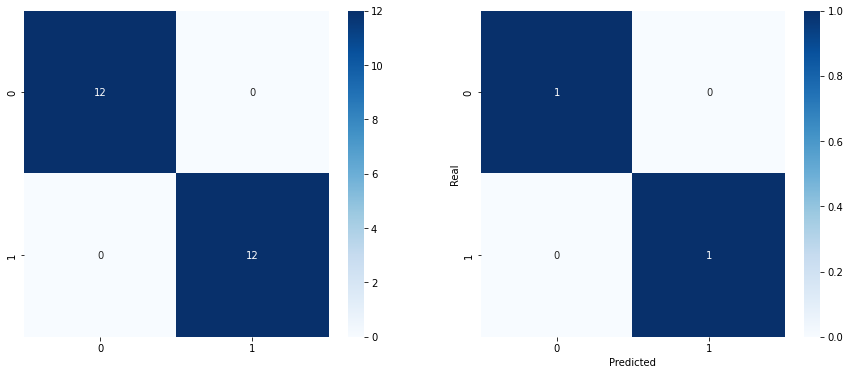

In [32]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

sns.heatmap(confusion_matrix(X_test['label'], X_test['predict']), annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_matrix(X_test['label'], X_test['predict'], normalize='true'), annot=True, cmap='Blues', ax=axs[1])

plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

# Iris

In [33]:
from sklearn.datasets import load_iris

In [34]:
data = load_iris()
df_iris = pd.DataFrame(data.data, columns=data.feature_names)
df_iris['target'] = pd.Series(data.target)

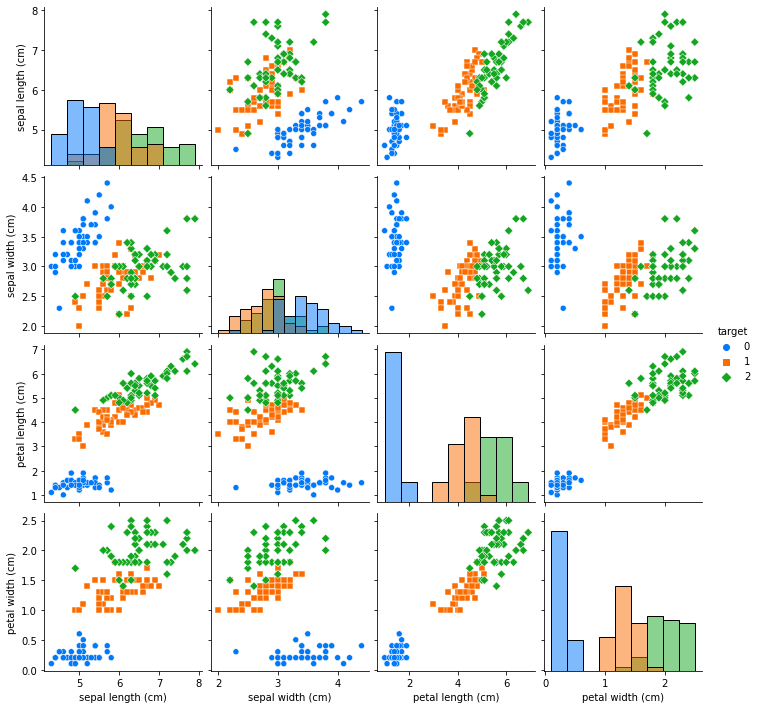

In [36]:
sns.pairplot(df_iris, hue='target', diag_kind="hist", palette={0: '#0079fa', 1: '#fa6c00', 2: '#14a620'},markers=["o", "s", "D"])

In [37]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_iris.copy(), col_target='target', train_size=0.7, stratify=True)

In [38]:
gmm = GaussianMixtureModel(dict_k={0:1, 1:2, 2:2}, threshold=0.1, iter=2)

In [39]:
gmm.fit(X_train, y_train, verbose=True)

**************************************** INICIALIZATION ****************************************
Class 0
     Component 0
          Coeficient Mixture: 1.0
          Gaussian:
               Média da Gaussian: [4.7, 3.2, 1.6, 0.2]
               Covariancia: [[0.12067226890756308, 0.08957983193277311, 0.016302521008403372, 0.00798319327731092], [0.08957983193277311, 0.1372773109243698, 0.008369747899159657, 0.004672268907563023], [0.016302521008403372, 0.008369747899159657, 0.0319831932773109, 0.006857142857142859], [0.00798319327731092, 0.004672268907563023, 0.006857142857142859, 0.012403361344537817]]
Class 1
     Component 0
          Coeficient Mixture: 0.5
          Gaussian:
               Média da Gaussian: [6.0, 2.7, 5.1, 1.6]
               Covariancia: [[0.2231428571428571, 0.046042016806722694, 0.10163025210084037, 0.031302521008403375], [0.046042016806722694, 0.08616806722689076, 0.042932773109243705, 0.03138655462184874], [0.10163025210084037, 0.042932773109243705, 0.12381

,0,component_choose,probability
0,1.0,0,0.007192
1,1.0,0,1.786249
2,1.0,0,0.594425
3,1.0,0,3.112839
4,1.0,0,0.275303


Class 1


,0,1,component_choose,probability
0,0.174345,0.825655,1,0.005140
1,0.031325,0.968675,1,0.261602
2,0.964832,0.035168,0,0.050675
3,0.079506,0.920494,1,0.507279
4,0.205480,0.794520,1,0.032421


Class 2


,0,1,component_choose,probability
0,0.977240,0.022760,0,0.134398
1,0.072878,0.927122,1,0.002966
2,0.000358,0.999642,1,0.326599
3,0.192703,0.807297,1,0.212477
4,0.000931,0.999069,1,0.123655



 **************************************** MAXIMIZATION STEP ****************************************
Class 0
Component 0
New Mean [5.01428571 3.40857143 1.45142857 0.23714286]
New cov [[0.11722449 0.08702041 0.01583673 0.0077551 ]
 [0.08702041 0.1333551  0.00813061 0.00453878]
 [0.01583673 0.00813061 0.03106939 0.00666122]
 [0.0077551  0.00453878 0.00666122 0.01204898]]

Class 1
Component 0
New Mean [6.11700134 2.62671275 4.5836736  1.3662717 ]
New cov [[0.15828601 0.01444975 0.0627571  0.03130291]
 [0.01444975 0.07539427 0.04539547 0.02011173]
 [0.0627571  0.04539547 0.10528606 0.04992071]
 [0.03130291 0.02011173 0.04992071 0.03733674]]

Component 1
New Mean [6.05372485 2.90880504 4.33698446 1.3739108 ]
New cov [[0.24361591 0.06510011 0.11096802 0.03013455]
 [0.06510011 0.06184978 0.06254235 0.03478499]
 [0.11096802 0.06254235 0.10771939 0.04587393]
 [0.03013455 0.03478499 0.04587393 0.03412835]]

Class 2
Component 0
New Mean [7.03565717 2.93719168 5.65945806 2.12154745]
New cov [[ 0

,0,component_choose,probability
0,1.0,0,0.094392
1,1.0,0,6.015371
2,1.0,0,3.445738
3,1.0,0,4.374552
4,1.0,0,0.525382


Class 1


,0,1,component_choose,probability
0,0.485100,0.514900,1,0.476486
1,0.021630,0.978370,1,3.765380
2,0.972521,0.027479,0,0.389943
3,0.009635,0.990365,1,0.276013
4,0.060154,0.939846,1,1.080284


Class 2


,0,1,component_choose,probability
0,9.991629e-01,0.000837,0,0.298819
1,1.164771e-02,0.988352,1,0.104344
2,6.718909e-08,1.000000,1,0.323447
3,4.922083e-01,0.507792,1,0.437492
4,4.018858e-04,0.999598,1,0.393935



 **************************************** MAXIMIZATION STEP ****************************************
Class 0
Component 0
New Mean [5.01428571 3.40857143 1.45142857 0.23714286]
New cov [[0.11722449 0.08702041 0.01583673 0.0077551 ]
 [0.08702041 0.1333551  0.00813061 0.00453878]
 [0.01583673 0.00813061 0.03106939 0.00666122]
 [0.0077551  0.00453878 0.00666122 0.01204898]]

Class 1
Component 0
New Mean [6.12937802 2.61362551 4.57599193 1.35153321]
New cov [[0.13887125 0.01480626 0.05954377 0.03859433]
 [0.01480626 0.0711897  0.04222169 0.01637036]
 [0.05954377 0.04222169 0.10885652 0.05603716]
 [0.03859433 0.01637036 0.05603716 0.04104626]]

Component 1
New Mean [6.04889181 2.91095087 4.34392396 1.38059902]
New cov [[0.25062843 0.06606804 0.11089408 0.02737298]
 [0.06606804 0.06158386 0.06323831 0.03427132]
 [0.11089408 0.06323831 0.10855013 0.04463467]
 [0.02737298 0.03427132 0.04463467 0.03221486]]

Class 2
Component 0
New Mean [7.09295266 2.91714812 5.77361685 2.1322085 ]
New cov [[ 0

In [40]:
X_test['predict'] = gmm.predict(X_test)
X_test['label'] = y_test

In [41]:
print(classification_report(X_test['label'], X_test['predict']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



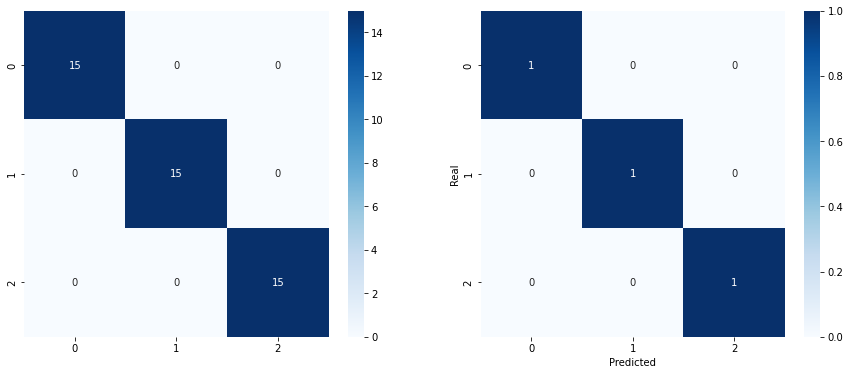

In [43]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

sns.heatmap(confusion_matrix(X_test['label'], X_test['predict']), annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_matrix(X_test['label'], X_test['predict'], normalize='true'), annot=True, cmap='Blues', ax=axs[1])

plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

# Spine

In [44]:
list_col_names = ['incidencia_pelvica', 
                  'inclinacao_pelvica', 
                  'angulo_lordose_lombar', 
                  'inclinacao_sacral', 
                  'radio_pelvico',
                  'grau_espondilolistese', 'target']

df_spine = pd.read_csv('./datasets/vertebral_column/column_3C.dat', names = list_col_names, sep=' ')
dict_ = dict(zip(df_spine['target'].unique().tolist(), range(len(df_spine['target'].unique().tolist()))))

df_spine['target'] = df_spine['target'].apply(lambda row: dict_[row])

for col in df_spine.columns:
    if col != 'target':
        df_spine = utils.normalize_col(df_spine, col)

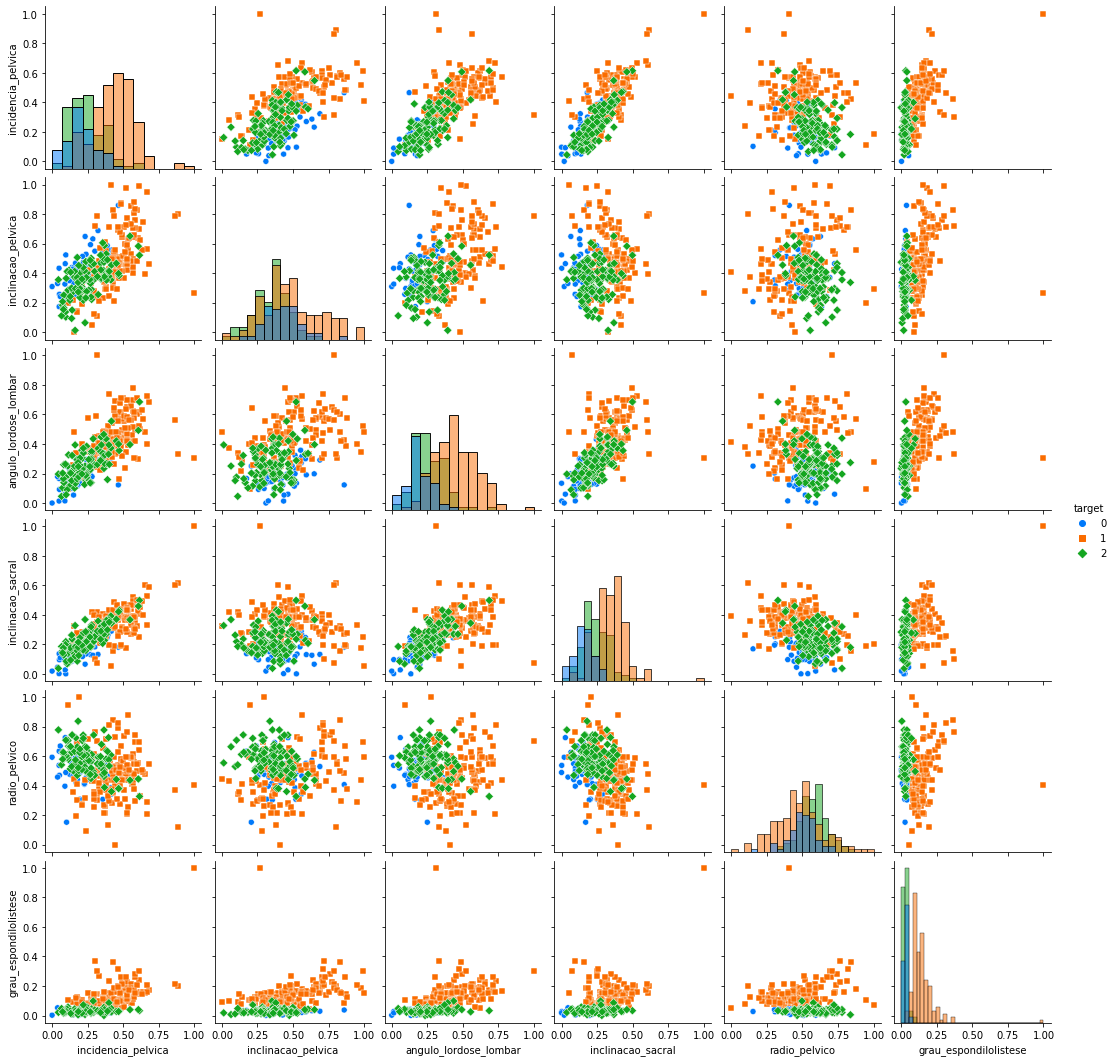

In [46]:
sns.pairplot(df_spine,hue='target', diag_kind="hist", palette={0: '#0079fa', 1: '#fa6c00', 2: '#14a620'},markers=["o", "s", "D"])

In [45]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_spine.copy(), col_target='target', train_size=0.7, stratify=True)

In [64]:
gmm = GaussianMixtureModel(dict_k={0:2, 1:2, 2:2}, threshold=0.1, iter=5)

In [65]:
gmm.fit(X_train, y_train, verbose=True)

**************************************** INICIALIZATION ****************************************
Class 0
     Component 0
          Coeficient Mixture: 0.5
          Gaussian:
               Média da Gaussian: [0.38715277777777785, 0.5873526259378349, 0.29980311437265084, 0.24606699981491767, 0.5499516076997527, 0.02388268156424581]
               Covariancia: [[0.011370896541119136, 0.01099626708365048, 0.005541717352250452, 0.005213611940237816, -0.0014016795488675483, 0.00033332467262250204], [0.01099626708365048, 0.018334738411303036, 0.004215360198152875, 0.0010532401512797782, 0.0008717812765455774, -1.9557370759478185e-05], [0.005541717352250452, 0.004215360198152875, 0.007858986874564955, 0.003132871719234257, -0.0005070667661257866, 0.00032156638845852063], [0.005213611940237816, 0.0010532401512797782, 0.003132871719234257, 0.004456362534267495, -0.0017967446592734055, 0.00032983875419033924], [-0.0014016795488675483, 0.0008717812765455774, -0.0005070667661257866, -0.001796744

,0,1,component_choose,probability
0,0.999827,0.000173,0,1.023945e+01
1,0.999626,0.000374,0,1.536904e+06
2,0.924418,0.075582,0,2.330468e+03
3,0.999695,0.000305,0,1.511930e+06
4,0.999081,0.000919,0,8.189516e+04


Class 1


,0,1,component_choose,probability
0,0.881997,0.118003,0,1.470935e+04
1,0.439184,0.560816,1,1.495586e+04
2,0.313989,0.686011,1,1.319955e-13
3,0.527275,0.472725,0,3.253807e+03
4,0.138280,0.861720,1,2.930095e+05


Class 2


,0,1,component_choose,probability
0,0.009567,0.990433,1,4.630702e+07
1,0.173991,0.826009,1,1.770035e+06
2,0.091421,0.908579,1,7.925614e+04
3,0.911991,0.088009,0,3.903526e+06
4,0.158587,0.841413,1,1.339022e+07



 **************************************** MAXIMIZATION STEP ****************************************
Class 0
Component 0
New Mean [0.20901859 0.42252962 0.19948912 0.16053643 0.48564462 0.03333532]
New cov [[ 9.85976804e-03  8.45954589e-03  5.99610612e-03  5.07731140e-03
  -9.65002674e-04  3.10916312e-04]
 [ 8.45954589e-03  1.39325876e-02  5.13212743e-03  8.98892389e-04
   1.73936391e-03 -6.17032854e-05]
 [ 5.99610612e-03  5.13212743e-03  7.65906709e-03  3.09409903e-03
  -7.09305854e-04  3.27023962e-04]
 [ 5.07731140e-03  8.98892389e-04  3.09409903e-03  4.40550703e-03
  -1.82704182e-03  3.30160270e-04]
 [-9.65002674e-04  1.73936391e-03 -7.09305854e-04 -1.82704182e-03
   8.66191691e-03 -1.57079344e-04]
 [ 3.10916312e-04 -6.17032854e-05  3.27023962e-04  3.30160270e-04
  -1.57079344e-04  1.69806092e-04]]

Component 1
New Mean [0.31131001 0.65202323 0.12154557 0.13984492 0.43182377 0.03527151]
New cov [[ 2.51893336e-02  3.24996253e-02  1.62813211e-03  7.33798874e-03
  -3.94920750e-03  4.1

,0,1,component_choose,probability
0,1.000000,3.213288e-25,0,1.080206e+04
1,1.000000,9.332040e-08,0,4.711683e+07
2,0.997371,2.628828e-03,0,3.282784e+06
3,0.999971,2.916981e-05,0,6.751403e+07
4,1.000000,3.241650e-09,0,1.212563e+06


Class 1


,0,1,component_choose,probability
0,0.864698,0.135302,0,3.557406e+04
1,0.293421,0.706579,1,4.146094e+04
2,0.999989,0.000011,0,1.276800e-09
3,0.349104,0.650896,1,8.343528e+04
4,0.121524,0.878476,1,1.384048e+06


Class 2


,0,1,component_choose,probability
0,0.017344,0.982656,1,4.428024e+07
1,0.092266,0.907734,1,3.930439e+06
2,0.032169,0.967831,1,2.263702e+06
3,0.987747,0.012253,0,3.574659e+06
4,0.276214,0.723786,1,2.131082e+07



 **************************************** MAXIMIZATION STEP ****************************************
Class 0
Component 0
New Mean [0.20860625 0.421652   0.19962377 0.16059565 0.48579247 0.03334554]
New cov [[ 9.99493600e-03  8.57238589e-03  6.07844671e-03  5.14851428e-03
  -9.67525285e-04  3.13390888e-04]
 [ 8.57238589e-03  1.39956188e-02  5.26100564e-03  9.74478737e-04
   1.79988863e-03 -6.17543112e-05]
 [ 6.07844671e-03  5.26100564e-03  7.72145842e-03  3.10632043e-03
  -7.31640624e-04  3.34145995e-04]
 [ 5.14851428e-03  9.74478737e-04  3.10632043e-03  4.43465178e-03
  -1.86081457e-03  3.32560704e-04]
 [-9.67525285e-04  1.79988863e-03 -7.31640624e-04 -1.86081457e-03
   8.69002619e-03 -1.59134270e-04]
 [ 3.13390888e-04 -6.17543112e-05  3.34145995e-04  3.32560704e-04
  -1.59134270e-04  1.71524832e-04]]

Component 1
New Mean [0.31985826 0.67027654 0.11852997 0.13858702 0.42867233 0.03508213]
New cov [[ 2.08604373e-02  2.65482435e-02  9.63410922e-04  6.26825049e-03
  -3.13220985e-03  3.7

In [66]:
X_test['predict'] = gmm.predict(X_test)
X_test['label'] = y_test

In [67]:
print(classification_report(X_test['label'], X_test['predict']))

              precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.98      1.00      0.99        45
           2       0.70      0.70      0.70        30

    accuracy                           0.81        93
   macro avg       0.74      0.73      0.73        93
weighted avg       0.80      0.81      0.80        93



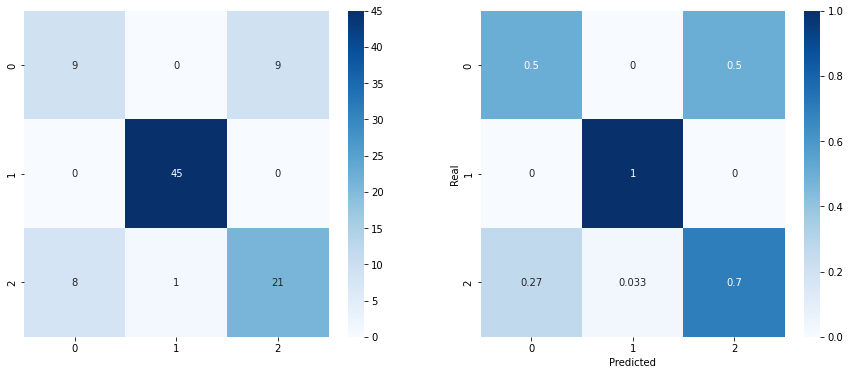

In [68]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

sns.heatmap(confusion_matrix(X_test['label'], X_test['predict']), annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_matrix(X_test['label'], X_test['predict'], normalize='true'), annot=True, cmap='Blues', ax=axs[1])

plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

# Dermatology

In [69]:
list_col_names = [
      'erythema',
      'scaling',
      'definite borders',
      'itching',
      'koebner phenomenon',
      'polygonal papules',
      'follicular papules',
      'oral mucosal involvement',
      'knee and elbow involvement',
     'scalp involvement',
     'family history',
     'melanin incontinence',
     'eosinophils in the infiltrate',
     'PNL infiltrate',
     'fibrosis of the papillary dermis',
     'exocytosis',
     'acanthosis',
     'hyperkeratosis',
     'parakeratosis',
     'clubbing of the rete ridges',
     'elongation of the rete ridges',
     'thinning of the suprapapillary epidermis',
     'spongiform pustule',
     'munro microabcess',
     'focal hypergranulosis',
     'disappearance of the granular layer',
     'vacuolisation and damage of basal layer',
     'spongiosis',
     'saw-tooth appearance of retes',
     'follicular horn plug',
     'perifollicular parakeratosis',
     'inflammatory monoluclear inflitrate',
     'band-like infiltrate',
     'age', 
     'target']

df_dermatology = pd.read_csv('./datasets/dermatology/dermatology.data', names = list_col_names)
df_dermatology['age'] =  pd.to_numeric(df_dermatology['age'], downcast='integer', errors='coerce')

df_dermatology['target'] = df_dermatology['target'].apply(lambda y: (y - 1)) # Formatando a variável resposta para começar do 0

df_dermatology = df_dermatology.fillna(df_dermatology.mean()).astype('int32') # Preenchendo valores null com média

In [70]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_dermatology.copy(), col_target='target', train_size=0.7, stratify=True)

In [74]:
gmm = GaussianMixtureModel(dict_k={0:1, 1:1, 2:1, 3:1, 4:1, 5:1}, threshold=0.1, iter=5)

In [75]:
gmm.fit(X_train, y_train, verbose=True)

**************************************** INICIALIZATION ****************************************
Class 0
     Component 0
          Coeficient Mixture: 1.0
          Gaussian:
               Média da Gaussian: [1, 1, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 2, 1, 2, 3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 55]
               Covariancia: [[0.42840492840492894, 0.1458541458541459, 0.07425907425907424, -0.03896103896103896, -0.012820512820512801, 0.0, -0.08158508158508156, 0.0, -0.029970029970030045, -0.0652680652680653, 0.03413253413253415, 0.0, 0.013486513486513486, 0.009823509823509805, 0.0, 0.020646020646020648, 0.009324009324009341, -0.058608058608058636, 0.030636030636030577, -0.10239760239760237, -0.03180153180153178, -0.08208458208458211, 0.011488511488511495, -0.12687312687312677, 0.0, 0.011322011322011325, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041625041625041645, -0.02547452547452547, 1.5947385947385952], [0.1458541458541459, 0.4135864135864134, 0.1698301698301699, 0.025974025974025976,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


,0,component_choose,probability
0,1.0,0,7.300095e-29
1,1.0,0,9.102749e-28
2,1.0,0,8.932666e-27
3,1.0,0,8.286327e-27
4,1.0,0,1.039284e-28


Class 1


,0,component_choose,probability
0,1.0,0,9.474043e-13
1,1.0,0,9.470578e-16
2,1.0,0,5.825491e-15
3,1.0,0,5.558201e-14
4,1.0,0,5.384700e-13


Class 2


,0,component_choose,probability
0,1.0,0,2.028997e-21
1,1.0,0,1.596139e-16
2,1.0,0,3.834704e-13
3,1.0,0,2.028997e-21
4,1.0,0,3.957740e-18


Class 3


,0,component_choose,probability
0,1.0,0,1.911727e-17
1,1.0,0,4.175045e-20
2,1.0,0,4.695201e-15
3,1.0,0,3.622695e-17
4,1.0,0,2.458402e-15


Class 4


,0,component_choose,probability
0,1.0,0,3.199577e-20
1,1.0,0,1.087664e-13
2,1.0,0,1.619159e-17
3,1.0,0,4.128846e-13
4,1.0,0,3.533371e-17


Class 5


,0,component_choose,probability
0,1.000000+0.000000j,0,2.247263e-17+0.000000e+00j
1,1.000000+0.000000j,0,2.247263e-17+0.000000e+00j
2,1.000000+0.000000j,0,2.247263e-17+0.000000e+00j
3,1.000000+0.000000j,0,2.247263e-17+0.000000e+00j
4,1.000000+0.000000j,0,2.247263e-17+0.000000e+00j



 **************************************** MAXIMIZATION STEP ****************************************
Class 0
Component 0
New Mean [2.32051282e+00 2.23076923e+00 2.05128205e+00 1.00000000e+00
 6.79487179e-01 0.00000000e+00 5.12820513e-02 0.00000000e+00
 1.69230769e+00 1.64102564e+00 2.94871795e-01 0.00000000e+00
 3.84615385e-02 1.08974359e+00 0.00000000e+00 2.56410256e-01
 2.05128205e+00 8.20512821e-01 2.02564103e+00 2.11538462e+00
 2.21794872e+00 2.01282051e+00 8.84615385e-01 1.23076923e+00
 0.00000000e+00 1.20512821e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.87179487e+00
 3.84615385e-02 3.91282051e+01]
New cov [[ 4.22912558e-01  1.43984221e-01  7.33070348e-02 ...  4.10913872e-02
  -2.51479290e-02  1.57429323e+00]
 [ 1.43984221e-01  4.08284024e-01  1.67652860e-01 ... -8.87573964e-03
  -3.45167653e-02 -1.96252465e-01]
 [ 7.33070348e-02  1.67652860e-01  3.30703485e-01 ...  7.06771861e-02
  -4.04339250e-02  1.04470743e+00]
 ...
 [ 4.10913872e-02 -8.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in cdouble_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in cdouble_scalars
  from ipykernel import kernelapp as app


,0,component_choose,probability
0,1.0,0,9.526877e-16
1,1.0,0,2.588362e-14
2,1.0,0,6.081595e-14
3,1.0,0,4.165067e-15
4,1.0,0,6.848291e-15


Class 1


,0,component_choose,probability
0,1.0,0,2.103309e-10
1,1.0,0,4.766486e-13
2,1.0,0,2.131565e-11
3,1.0,0,3.447057e-10
4,1.0,0,1.914848e-11


Class 2


,0,component_choose,probability
0,1.0,0,1.238599e-16
1,1.0,0,1.041647e-10
2,1.0,0,2.858934e-10
3,1.0,0,1.238599e-16
4,1.0,0,9.685115e-15


Class 3


,0,component_choose,probability
0,1.0,0,2.638928e-15
1,1.0,0,3.598464e-15
2,1.0,0,2.481845e-12
3,1.0,0,1.188091e-13
4,1.0,0,5.239497e-12


Class 4


,0,component_choose,probability
0,1.0,0,2.521526e-15
1,1.0,0,8.905154e-11
2,1.0,0,3.088309e-12
3,1.0,0,1.376248e-10
4,1.0,0,3.385843e-11


Class 5


TypeError: ignored

In [ ]:
X_test['predict'] = gmm.predict(X_test)
X_test['label'] = y_test

In [ ]:
print(classification_report(X_test['label'], X_test['predict']))

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,6))

sns.heatmap(confusion_matrix(X_test['label'], X_test['predict']), annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_matrix(X_test['label'], X_test['predict'], normalize='true'), annot=True, cmap='Blues', ax=axs[1])

plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

In [ ]:
class GMM:

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        print(covs)

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self

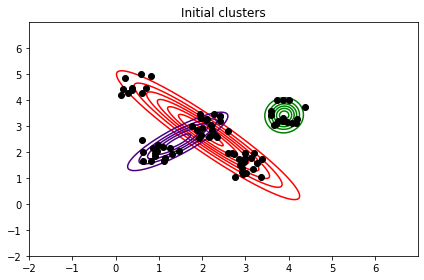

In [ ]:
gmm = GMM(n_components = 3, n_iters = 100, tol = 1e-4, seed = 4)
gmm.fit(df_artificial_1.drop(['target'], axis=1).values)

plot_contours(df_artificial_1.drop(['target'], axis=1).values, gmm.means, gmm.covs, 'Initial clusters')